# Creating TF-IDF

In [83]:
import pickle

# Load pickle file
with open('df_law_clean.pickle', 'rb') as f:
    df = pickle.load(f)

In [84]:
df.head()

afstemnings_id        dato_sagstrin  sag_id  \
0               2  2014-09-09T09:15:00    1449   
1               4  2012-11-06T00:00:00    5904   
2               5  2014-09-09T09:15:00    1449   
3               9  2014-06-11T09:00:00    1451   
4              10  2014-06-11T09:00:00     780   

                                               titel  \
0  Forslag til lov om ændring af virksomhedsskatt...   
1  Forslag til lov om akutjob og jobpræmie til ar...   
2  Forslag til lov om ændring af virksomhedsskatt...   
3  Forslag til lov om ændring af lov om trafiksel...   
4  Forslag til lov om projektering af nyanlæg og ...   

                                          titel_kort lovnummer_num  \
0  Om indgreb mod utilsigtet udnyttelse af virkso...           200   
1                                        Om akutjob.            46   
2  Om indgreb mod utilsigtet udnyttelse af virkso...           200   
3  Om Region Nordjyllands overtagelse af statens ...           136   
4  Om nyanlæg og hastighedsopgraderinger af jernb...           172   

                                              resume  periode_id  \
0  Loven ændrer virksomhedsskatteordningens regle...          32   
1  Med loven etableres en midlertidig ordning, så...          31   
2  Loven ændrer virksomhedsskatteordningens regle...          32   
3  Med loven åbnes der mulighed for, at Region No...          32   
4  Loven indeholder bemyndigelse til, at transpor...          32   

                                      votes_adjusted afstemnings_id_pfix  \
0  [{'id': 180, 'typeid': 1, 'afstemningid': 2, '...                  p2   
1  [{'id': 850407, 'typeid': 1, 'afstemningid': 4...                  p4   
2  [{'id': 164665, 'typeid': 1, 'afstemningid': 5...                  p5   
3  [{'id': 163591, 'typeid': 4, 'afstemningid': 9...                  p9   
4  [{'id': 163770, 'typeid': 1, 'afstemningid': 1...                 p10   

                       law_category_id  \
0                       [33062, 33754]   
1         [62218, 34460, 33270, 33070]   
2                       [33062, 33754]   
3                       [33056, 33086]   
4  [34460, 84356, 83647, 33917, 33364]   

                                  law_category_clean  
0             [Skatter og afgifter, virksomhedsskat]  
1  [akutjob og jobpræmie til arbejdsgivere, polit...  
2             [Skatter og afgifter, virksomhedsskat]  
3            [kollektiv transport, transportpolitik]  
4  [politisk aftale, projektering af nyanlæg og h...

In [9]:
# Extract law texts that a certain party has voted for


## TF-IDF

In [134]:
import numpy as np
import regex as re
import pandas as pd
import pickle
from collections import defaultdict

In [93]:
#First create a dict for each law that contains the majority vote for each party

#Function that returns the majority typeid for each party for a given law
def get_majority_typeid_for_party(law):
    #Create a dict with the party as key and the typeid as value
    party_typeid_dict = {}
    for vote in law:
        #If the party is not already in the dict, add it
        if vote['party'] not in party_typeid_dict:
            party_typeid_dict[vote['party']] = [vote['typeid']]
        #If the party is already in the dict, append the typeid to the list of typeids
        else:
            party_typeid_dict[vote['party']].append(vote['typeid'])
    #Create a dict with the party as key and the majority typeid as value
    party_majority_typeid_dict = {}
    for party in party_typeid_dict:
        #Get the most common typeid for each party
        party_majority_typeid_dict[party] = max(set(party_typeid_dict[party]), key=party_typeid_dict[party].count)
    return party_majority_typeid_dict

#create a new column in the votes_df_combined dataframe called majority_typeid_for_party
df['majority_party_vote'] = [get_majority_typeid_for_party(law) for law in df['votes_adjusted']]

In [23]:
#Function that creates a dict with all the text in 'resume' summed for each unique key in the majority_party_vote column if the key has the value 1 in the majority_party_vote (yes)
def get_text_for_party_yes(law_text_list, majority_party_vote_list):
    #Create a dict with the party as key and the text as value
    party_text_dict = {}
    for law_text, party_vote_dict in zip(law_text_list, majority_party_vote_list):
        for party in party_vote_dict:
        #If the party is not already in the dict, add it
            if party_vote_dict[party] == 1:
                if party not in party_text_dict:
                    party_text_dict[party] = law_text
                else:
                    party_text_dict[party] += law_text
    return party_text_dict

text_dict = get_text_for_party_yes(list(df['resume']), list(df['majority_party_vote']))


In [169]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
stopwords_dk = nltk.corpus.stopwords.words('danish')

# Functions to tokenize and calculate tf-idf for each party

def tokenize_party(party_text_dict):
    tokenized_party_dict = {}
    for party in party_text_dict:
        tokenized_party_dict[party] = word_tokenize(party_text_dict[party])
    return tokenized_party_dict

law_token_dict = tokenize_party(text_dict)


# Calculate the frequency distribution of the words in each party
#only process words, and consider all words as lower-case
def get_tf(tokenized_dict):
    freqDist_dict = {}
    for party in tokenized_dict.keys():
        freqDist_dict[party] = nltk.FreqDist(word.lower() for word in tokenized_dict[party] if word.isalpha() and word.lower() not in stopwords_dk)
    return freqDist_dict

law_tf = get_tf(law_token_dict)


def get_idf(freqDist_dict: dict):
    idf = {}

    #for each party
    for party in freqDist_dict.keys():
        #for each word in the law text of that party
        for word in freqDist_dict[party].keys():
            #if the word has not been IDF scored yet
            if word not in idf.keys():
                for freqDist in freqDist_dict.values():
                    if word in freqDist.keys():
                        #if the word is in the frequency dict of a given community, 1 to the IDF score
                        if word not in idf.keys():
                            idf[word] = 1
                        else:
                            idf[word] += 1
                #Divide the total number of communities ("documents ") with the number of communities in which the word appeared
                idf[word] = len(freqDist_dict.keys())/ idf[word]
                idf[word] = np.log2(idf[word])

    return idf

law_idf = get_idf(law_tf)

#normalize freqdist
def get_tf_norm(freqDist_dict: dict, token_dict: dict):
    tf = defaultdict()
    for party in freqDist_dict.keys():
        tf[party] = defaultdict()
        for word in freqDist_dict[party].keys():
            tf[party][word] = freqDist_dict[party][word]/len(token_dict[party])
    return tf

law_tf_norm = get_tf_norm(law_tf, law_token_dict)


# Calculate tf-idf
def get_tf_idf(tf_dict: dict, idf_dict: dict):
    tf_idf = defaultdict()
    for party in tf_dict.keys():
        tf_idf[party] = defaultdict()
        # For each word in the community, multiply the TF and IDF score
        for word in tf_dict[party].keys():
            tf_idf[party][word] = tf_dict[party][word] * idf_dict[word]
    return tf_idf

law_tf_idf = get_tf_idf(law_tf_norm, law_idf)

def law_text_to_tf_idf(text_dict):
    token_dict = tokenize_party(text_dict)
    tf_dict = get_tf(token_dict)
    tf_idf_dict = get_tf_idf(get_tf_norm(tf_dict, token_dict), get_idf(tf_dict))
    return tf_idf_dict

def token_to_tf_idf(token_dict):
    tf_dict = get_tf(token_dict)
    tf_idf_dict = get_tf_idf(get_tf_norm(tf_dict, token_dict), get_idf(tf_dict))
    return tf_idf_dict


In [152]:
# Get the top 5 words in each party before IDF sorting - clearly does not say anything unique about the party
for party in sorted(law_tf.keys()):
    print(f'{party} top 5 words: {law_tf[party].most_common(5)}')

Alternativet top 5 words: [('lovforslaget', 52), ('kan', 15), ('danmark', 14), ('regler', 13), ('kraft', 13)]
Dansk Folkeparti top 5 words: [('loven', 122), ('lovforslaget', 103), ('kan', 49), ('folkeparti', 42), ('regler', 40)]
Det Konservative Folkeparti top 5 words: [('loven', 136), ('lovforslaget', 101), ('kan', 53), ('folkeparti', 47), ('sikre', 43)]
Enhedslisten top 5 words: [('loven', 87), ('lovforslaget', 64), ('kan', 33), ('ved', 28), ('regler', 28)]
Inuit Ataqatigiit top 5 words: [('lovforslaget', 5), ('havmiljøet', 4), ('grønland', 4), ('krav', 4), ('ved', 3)]
Kristendemokraterne top 5 words: [('lovforslaget', 4), ('nødvendige', 3), ('række', 3), ('havbunden', 3), ('redskaber', 2)]
Liberal Alliance top 5 words: [('lovforslaget', 77), ('loven', 55), ('kan', 33), ('folkeparti', 31), ('mellem', 26)]
Ny Alliance top 5 words: [('loven', 4), ('miljøministeren', 2), ('bødeniveauet', 2), ('miljøbeskyttelsesloven', 2), ('overtrædelser', 2)]
Nye Borgerlige top 5 words: [('lovforslaget

In [173]:
# List the top 10 words in each party according to TF-IDF
for party in sorted(law_tf_idf.keys()):
    #round the [1] element of the tuple (the TF-IDF score) to 3 decimals
    print(f'{party} top 10 words: {[(word, round(score, 3)) for word, score in sorted(law_tf_idf[party].items(), key=lambda x: x[1], reverse=True)[:10]]}')


Alternativet top 10 words: [('havbrug', 0.002), ('lovforslaget', 0.001), ('udtjente', 0.001), ('fyringsanlæg', 0.001), ('havplanlægningen', 0.001), ('plastikbæreposer', 0.001), ('genanvendeligt', 0.001), ('mulighed', 0.001), ('projekter', 0.001), ('havplanen', 0.001)]
Dansk Folkeparti top 10 words: [('forbindelse', 0.001), ('nævnet', 0.001), ('sagkyndige', 0.001), ('l', 0.001), ('aftale', 0.001), ('virksomheder', 0.001), ('nr', 0.001), ('loven', 0.001), ('mulighed', 0.001), ('områder', 0.001)]
Det Konservative Folkeparti top 10 words: [('forbindelse', 0.001), ('aftale', 0.001), ('sagkyndige', 0.001), ('mulighed', 0.001), ('l', 0.001), ('nævnet', 0.001), ('virksomheder', 0.001), ('loven', 0.001), ('miljøområdet', 0.001), ('får', 0.001)]
Enhedslisten top 10 words: [('forbindelse', 0.001), ('mulighed', 0.001), ('l', 0.001), ('loven', 0.001), ('offentlige', 0.001), ('regeringens', 0.001), ('områder', 0.001), ('pant', 0.001), ('retursystem', 0.001), ('digital', 0.001)]
Inuit Ataqatigiit top

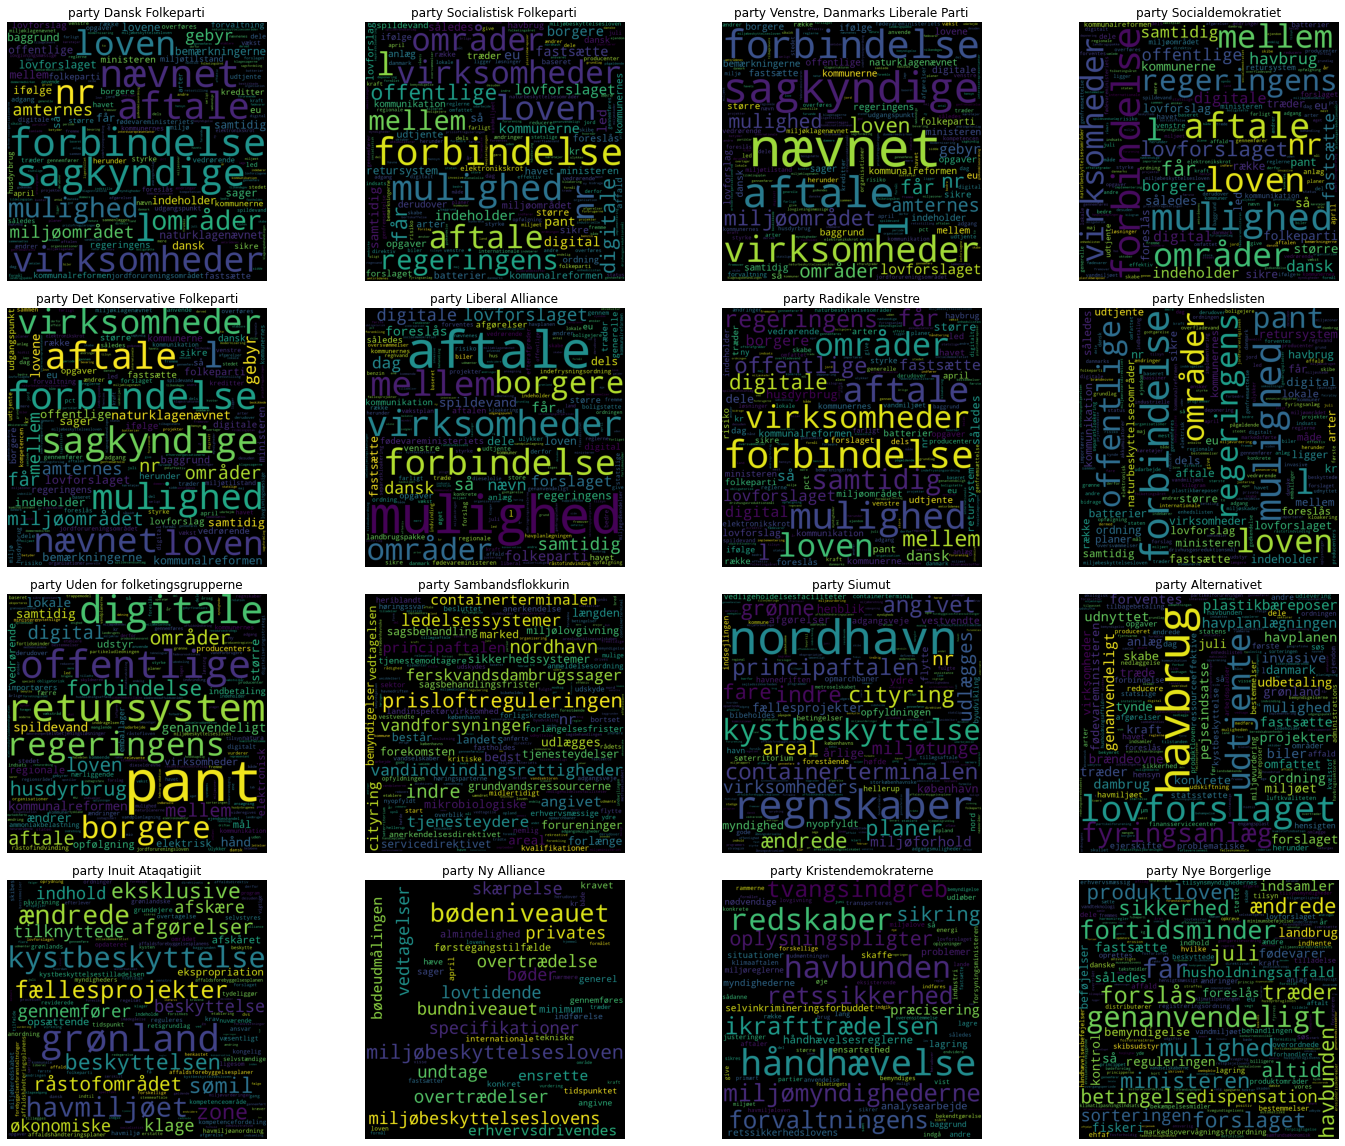

In [172]:
# Create a word cloud for each community

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib import colors
from matplotlib.lines import Line2D

from wordcloud import WordCloud

fig, axs = plt.subplots(figsize=(20, 20))
plt.subplots_adjust(hspace=0.1, wspace=0.05)
#fig.suptitle("Wordclouds of the parties", fontsize=16)

for n, party in enumerate(law_tf_idf.keys()):
    wordcloud = WordCloud(
                width = 800, 
                height = 800,
                background_color ='black',
                stopwords = stopwords_dk,
                collocations=False,
                ).generate_from_frequencies(law_tf_idf[party])
    
    # Create a subplot of the wordcloud
    ax = plt.subplot(5, 4, n+1)
    
    ax.imshow(wordcloud)
    ax.axis("off")
    ax.set_title(f'party {party}')

fig.tight_layout()
plt.show()

In [64]:
#Remove all smaller partiers to avoid a scewed TD-IDF score because some parties have only been part of the parilaiment work for a reduced period of time

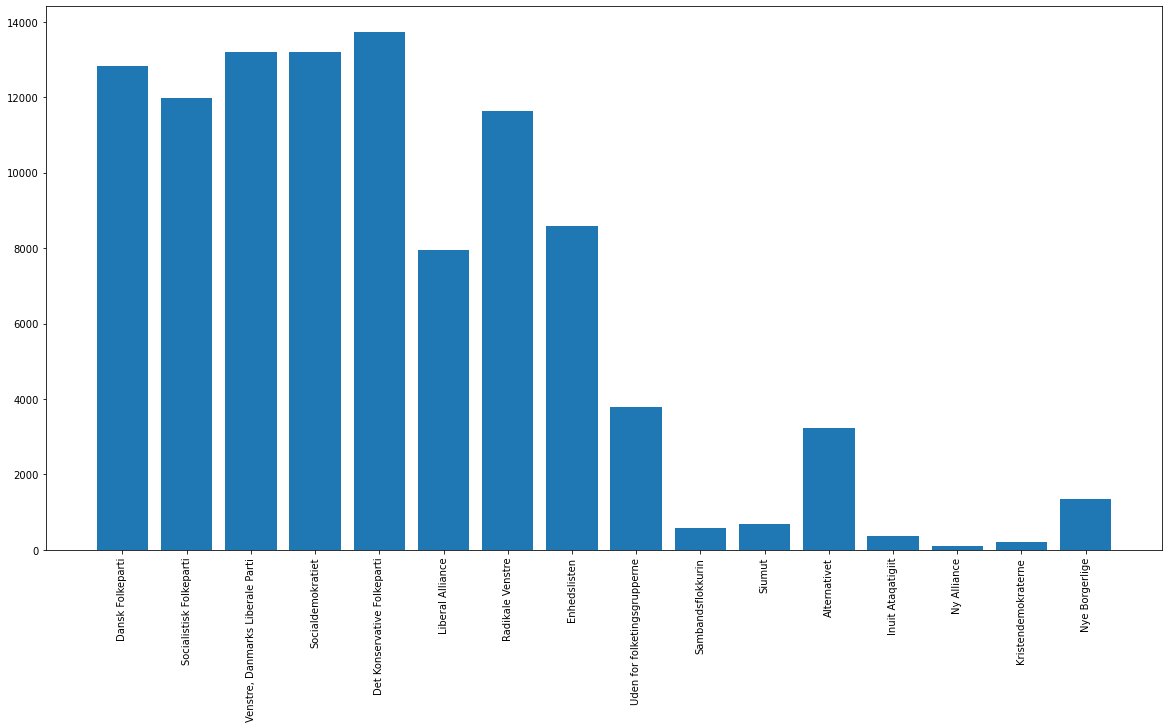

In [158]:
#plot the number of words in each party
plt.figure(figsize=(20, 10))
plt.bar(law_token_dict.keys(), [len(law_token_dict[party]) for party in law_token_dict.keys()])
plt.xticks(rotation=90)
plt.show()

In [162]:
subset_law_token = law_token_dict.copy()
small_parties =  ['Inuit Ataqatigiit', 'Tjóðveldi', 'Fólkaflokkurin', 'Tjóðveldisflokkurin', 'Uden for folketingsgrupperne', 'Sambandsflokkurin', 'Siumut', 'Ny Alliance', 'Kristendemokraterne', 'Nye Borgerlige']
#Remoev list of small parties from the subset_law_token dict
for party in small_parties:
    if party in subset_law_token.keys():
        del subset_law_token[party]

In [165]:
subset_tf_idf = token_to_tf_idf(subset_law_token)

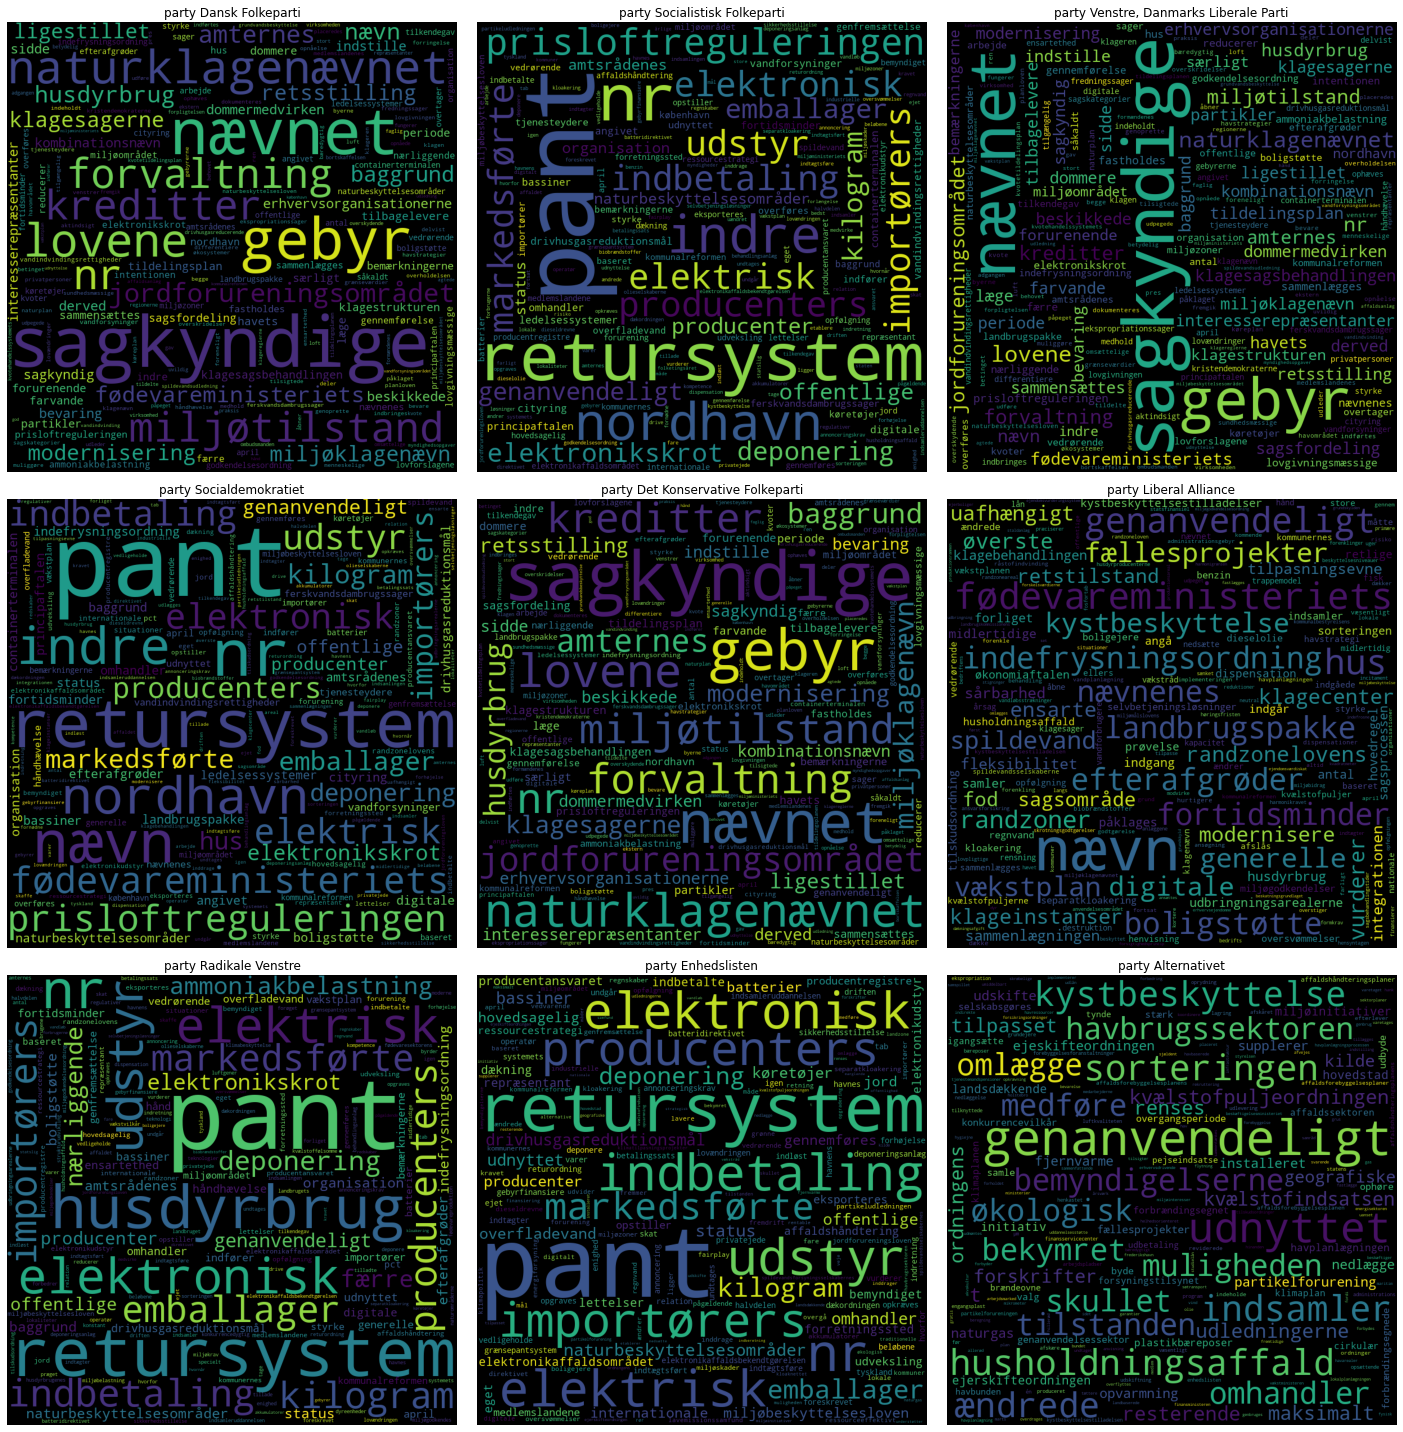

In [171]:
# Create a word cloud for each community

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib import colors
from matplotlib.lines import Line2D

from wordcloud import WordCloud

fig, axs = plt.subplots(figsize=(20, 20))
plt.subplots_adjust(hspace=0.1, wspace=0.05)
#fig.suptitle("Wordclouds of the parties", fontsize=16)

for n, party in enumerate(subset_tf_idf.keys()):
    wordcloud = WordCloud(
                width = 800, 
                height = 800,
                background_color ='black',
                stopwords = stopwords_dk,
                collocations=False,
                ).generate_from_frequencies(subset_tf_idf[party])
    
    # Create a subplot of the wordcloud
    ax = plt.subplot(3, 3, n+1)
    
    ax.imshow(wordcloud)
    ax.axis("off")
    ax.set_title(f'party {party}')

fig.tight_layout()
plt.show()

## Only for enviroment

In [85]:
df.head()

afstemnings_id        dato_sagstrin  sag_id  \
0               2  2014-09-09T09:15:00    1449   
1               4  2012-11-06T00:00:00    5904   
2               5  2014-09-09T09:15:00    1449   
3               9  2014-06-11T09:00:00    1451   
4              10  2014-06-11T09:00:00     780   

                                               titel  \
0  Forslag til lov om ændring af virksomhedsskatt...   
1  Forslag til lov om akutjob og jobpræmie til ar...   
2  Forslag til lov om ændring af virksomhedsskatt...   
3  Forslag til lov om ændring af lov om trafiksel...   
4  Forslag til lov om projektering af nyanlæg og ...   

                                          titel_kort lovnummer_num  \
0  Om indgreb mod utilsigtet udnyttelse af virkso...           200   
1                                        Om akutjob.            46   
2  Om indgreb mod utilsigtet udnyttelse af virkso...           200   
3  Om Region Nordjyllands overtagelse af statens ...           136   
4  Om nyanlæg og hastighedsopgraderinger af jernb...           172   

                                              resume  periode_id  \
0  Loven ændrer virksomhedsskatteordningens regle...          32   
1  Med loven etableres en midlertidig ordning, så...          31   
2  Loven ændrer virksomhedsskatteordningens regle...          32   
3  Med loven åbnes der mulighed for, at Region No...          32   
4  Loven indeholder bemyndigelse til, at transpor...          32   

                                      votes_adjusted afstemnings_id_pfix  \
0  [{'id': 180, 'typeid': 1, 'afstemningid': 2, '...                  p2   
1  [{'id': 850407, 'typeid': 1, 'afstemningid': 4...                  p4   
2  [{'id': 164665, 'typeid': 1, 'afstemningid': 5...                  p5   
3  [{'id': 163591, 'typeid': 4, 'afstemningid': 9...                  p9   
4  [{'id': 163770, 'typeid': 1, 'afstemningid': 1...                 p10   

                       law_category_id  \
0                       [33062, 33754]   
1         [62218, 34460, 33270, 33070]   
2                       [33062, 33754]   
3                       [33056, 33086]   
4  [34460, 84356, 83647, 33917, 33364]   

                                  law_category_clean  
0             [Skatter og afgifter, virksomhedsskat]  
1  [akutjob og jobpræmie til arbejdsgivere, polit...  
2             [Skatter og afgifter, virksomhedsskat]  
3            [kollektiv transport, transportpolitik]  
4  [politisk aftale, projektering af nyanlæg og h...

In [94]:
#create a df but only with rows that contain the word 'Miljø' as one of the strings in list of strings in the law_category_clean column
df_miljo = df[df['law_category_clean'].apply(lambda x: 'Miljø' in x)]


In [103]:
df_miljo.shape
#I dont understand why there is only 131 laws with miljø in the law_category_clean column, plot from scrape love shows close to 200 laws with the clean category miljø

(131, 13)

In [113]:
text_dict = get_text_for_party_yes(list(df_miljo['resume']), list(df_miljo['majority_party_vote']))
token_dict = tokenize_party(text_dict)
freqDist = get_freqDist(token_dict)
tf = get_tf_norm(freqDist, token_dict)
idf = get_idf(freqDist)